In [6]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, MegaForSequenceClassification
import torchinfo
import os
import pickle

In [7]:
device = torch.device("cpu")


In [8]:
tokenizer = AutoTokenizer.from_pretrained("mnaylor/mega-base-wikitext")
model = MegaForSequenceClassification.from_pretrained(
    "mnaylor/mega-base-wikitext")
model.to(device)

torchinfo.summary(model)

Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                            Param #
MegaForSequenceClassification                                     --
├─MegaModel: 1-1                                                  --
│    └─MegaEmbeddings: 2-1                                        --
│    │    └─Embedding: 3-1                                        6,433,920
│    └─ModuleList: 2-2                                            --
│    │    └─MegaBlock: 3-2                                        223,042
│    │    └─MegaBlock: 3-3                                        223,042
│    │    └─MegaBlock: 3-4                                        223,042
│    │    └─MegaBlock: 3-5                                        223,042
├─MegaClassificationHead: 1-2                                     --
│    └─Linear: 2-3                                                16,512
│    └─Dropout: 2-4                                               --
│    └─Linear: 2-5                                                2

In [9]:
print(model)

MegaForSequenceClassification(
  (mega): MegaModel(
    (embedding_layer): MegaEmbeddings(
      (word_embeddings): Embedding(50265, 128, padding_idx=1)
    )
    (layers): ModuleList(
      (0-3): 4 x MegaBlock(
        (mega_layer): MegaMovingAverageGatedAttention(
          (activation): SiLU()
          (dropout): MegaDropout()
          (hidden_dropout): MegaDropout()
          (attention_dropout): MegaDropout()
          (norm): MegaSequenceNorm(
            (norm): MegaScaleNorm()
          )
          (ema_gate): MegaMultiDimensionDampedEma()
          (v_proj): Linear(in_features=128, out_features=256, bias=True)
          (mx_proj): Linear(in_features=128, out_features=576, bias=True)
          (h_proj): Linear(in_features=256, out_features=128, bias=True)
          (rel_pos_bias): MegaRotaryRelativePositionalBias()
          (softmax): Softmax(dim=-1)
        )
        (nffn): MegaNormalizedFeedForwardNetwork(
          (activation): SiLU()
          (dropout): MegaDropout()

In [10]:
import pandas as pd

data_check_test = load_dataset(
    "csv", data_files="datasets/Hatemoji-main/HatemojiCheck/test.csv"
    )
print(data_check_test['train'][0])

# Dataset only have training data, hence split it into train/test
data_check_test = data_check_test['train'].train_test_split(test_size=0.25)


{'case_id': 0, 'templ_id': 1.0, 'test_group_id': 1, 'text': 'I want to 🔪 all women', 'target': 'women', 'functionality': 'verb_swap', 'set': 'orig', 'label_gold': 1, 'unrealistic_flags': 0, 'included_in_test_suite': 1}


In [11]:
def tokenize_func(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True
        )

tokenized_data = data_check_test.map(tokenize_func, batched=True)


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

In [12]:
# Prepare for torch
from torch.utils.data import DataLoader

tokenized_data = tokenized_data.remove_columns([
    "text", "case_id", "templ_id", "test_group_id", "target", "functionality", "set", "unrealistic_flags", "included_in_test_suite"])

tokenized_data = tokenized_data.rename_column("label_gold", "labels")
tokenized_data.set_format("torch")

print(tokenized_data)


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2947
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 983
    })
})


In [13]:

train_dataloader = DataLoader(
    tokenized_data['train'], batch_size=64, shuffle=True)
test_dataloader = DataLoader(tokenized_data['test'], batch_size=64)

### fine-tuning

In [14]:
from tqdm.auto import tqdm
import evaluate
import matplotlib.pyplot as plt
from transformers import get_scheduler
from torch.optim import AdamW
import copy

def train_epoch(model, train_dataloader, optimizer, lr_scheduler):
    progress_bar = tqdm(range(len(train_dataloader)))
    metric = evaluate.load("accuracy")
    model.train()
    criterion = torch.nn.CrossEntropyLoss()

    epoch_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits
        loss = criterion(logits, batch["labels"])
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        predictions = torch.argmax(logits, dim=-1)
        
        metric.add_batch(predictions=predictions, references=batch["labels"])

        epoch_loss += loss.item()
        progress_bar.update(1)
    
    lr_scheduler.step()
    epoch_loss /= len(train_dataloader)
    accuracy = metric.compute()['accuracy']

    return epoch_loss, accuracy

def eval(model, test_dataloader):
    progress_bar = tqdm(range(len(test_dataloader)))
    metric = evaluate.load("accuracy")
    model.eval()
    model.mega.requires_grad_(False)
    criterion = torch.nn.CrossEntropyLoss()

    epoch_loss = 0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        loss = criterion(logits, batch["labels"])

        predictions = torch.argmax(logits, dim=-1)

        metric.add_batch(predictions=predictions, references=batch["labels"])

        epoch_loss += loss.item()
        progress_bar.update(1)

    epoch_loss /= len(test_dataloader)
    accuracy = metric.compute()['accuracy']
    
    return epoch_loss, accuracy

def train(model,
          train_dataloader,
          test_dataloader,
          num_epochs=2,
          learning_rate=5e-5,
          patience=2):

    # count epochs where the model didn't improve
    counter = 0
    best_val_acc = 0
    best_epoch = 0
    best_model = None

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    lr_scheduler = get_scheduler(
        name="polynomial", optimizer=optimizer, num_warmup_steps=1,     num_training_steps=num_epochs*len(train_dataloader)
    )
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model, train_dataloader, optimizer, lr_scheduler)
        val_loss, val_acc = eval(model, test_dataloader)

        print(f"Epoch {epoch+1} accuracy: train={train_acc:.3f}, test={val_acc:.3f}")

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Unfreeze MEGA
        if epoch >= 1:
            model.mega.requires_grad_(True)
            
        # early stopping
        if val_acc <= best_val_acc + 1e-4:
            counter += 1
            if counter >= patience:
                break
        else:
            best_val_acc = val_acc
            counter = 0
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())

    return train_accuracies, val_accuracies, train_losses, val_losses, best_epoch, best_model

model.mega.requires_grad_(False)
N_EPOCHS = 5
train_acc, val_acc, train_losses, val_losses, best_epoch, best_model = train(model, train_dataloader, test_dataloader, N_EPOCHS, learning_rate=1e-4)

all_data = (train_acc, val_acc, train_losses, val_losses, best_epoch, best_model)
with open(f"mega_hatemoji.obj", "wb") as f:
    pickle.dump(all_data, f)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.643, test=0.661


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.677, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.681, test=0.710


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.736, test=0.725


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.760, test=0.790


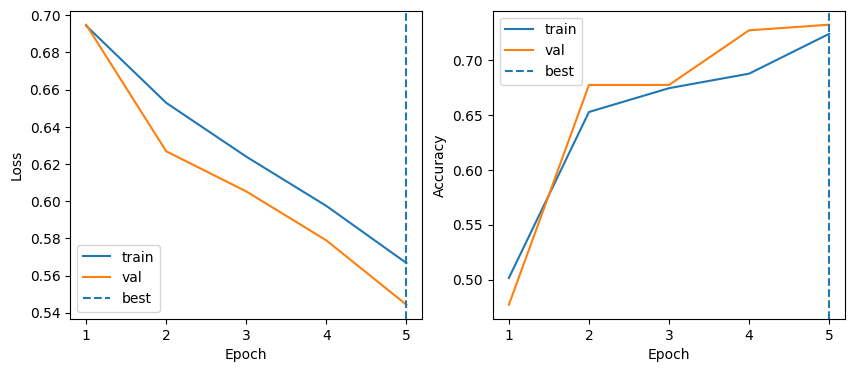

In [9]:
with open(f"mega_hatemoji.obj", "rb") as f:
    train_acc, val_acc, train_losses, val_losses, best_epoch, best_model = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
epoch_axis = range(1, len(train_losses)+1)
ax[0].plot(epoch_axis, train_losses, label='train')
ax[0].plot(epoch_axis, val_losses, label='val')
ax[0].axvline(best_epoch+1, label='best', linestyle='--')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(epoch_axis)
ax[0].legend()

ax[1].plot(epoch_axis, train_acc, label='train')
ax[1].plot(epoch_axis, val_acc, label='val')
ax[1].axvline(best_epoch+1, label='best', linestyle='--')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(epoch_axis)
ax[1].legend()
plt.show()

### Evaluating

In [16]:

best_train_accs = []
best_train_losses = []
best_val_accs = []
best_val_losses = []

best_epochs = []

all_train_accs = []
all_train_losses = []
all_val_accs = []
all_val_losses = []

N_SEEDS = 5
N_EPOCHS = 20
for seed in tqdm(range(N_SEEDS)):
    model = MegaForSequenceClassification.from_pretrained(
    "mnaylor/mega-base-wikitext")
    model.to(device)
    model.mega.requires_grad_(False)
      
    train_acc, val_acc, train_losses, val_losses, best_epoch, _ = train(model, train_dataloader, test_dataloader, N_EPOCHS, learning_rate=1e-4, patience=2)

    best_train_accs.append(train_acc[best_epoch])
    best_val_accs.append(val_acc[best_epoch])
    best_train_losses.append(train_losses[best_epoch])
    best_val_losses.append(val_losses[best_epoch])
    best_epochs.append(best_epoch)

    all_train_accs.append(train_acc)
    all_train_losses.append(train_losses)
    all_val_accs.append(val_acc)
    all_val_losses.append(val_losses)

all_data_seeds = (best_train_accs, best_val_accs, best_train_losses, best_val_losses, best_epochs, all_train_accs, all_train_losses, all_val_accs, all_val_losses)

with open(f"mega_hatemoji_seeds.obj", "wb") as f:
    pickle.dump(all_data_seeds, f)

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.427, test=0.387


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.662, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.678, test=0.675


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.719, test=0.756


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.762, test=0.785


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.801, test=0.821


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.840, test=0.859


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.870, test=0.899


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.898, test=0.910


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.913, test=0.937


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.928, test=0.929


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.940, test=0.950


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.955, test=0.955


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.958, test=0.962


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.966, test=0.957


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.960, test=0.963


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 accuracy: train=0.971, test=0.973


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 accuracy: train=0.968, test=0.972


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 accuracy: train=0.975, test=0.961


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 accuracy: train=0.980, test=0.963


Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.397, test=0.353


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.661, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.681, test=0.706


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.729, test=0.739


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.758, test=0.767


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.785, test=0.807


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.823, test=0.846


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.849, test=0.892


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.881, test=0.904


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.899, test=0.928


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.909, test=0.941


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.938, test=0.962


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.948, test=0.942


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.937, test=0.951


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.960, test=0.958


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.967, test=0.969


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 accuracy: train=0.969, test=0.979


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 accuracy: train=0.976, test=0.980


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 accuracy: train=0.977, test=0.977


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 accuracy: train=0.986, test=0.984


Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.418, test=0.374


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.670, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.679, test=0.694


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.723, test=0.753


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.761, test=0.782


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.803, test=0.845


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.841, test=0.866


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.872, test=0.914


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.887, test=0.928


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.913, test=0.943


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.923, test=0.954


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.943, test=0.961


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.956, test=0.967


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.956, test=0.965


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.968, test=0.970


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.968, test=0.980


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 accuracy: train=0.969, test=0.973


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 accuracy: train=0.978, test=0.974


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 accuracy: train=0.978, test=0.980


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 accuracy: train=0.981, test=0.982


Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.383, test=0.356


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.653, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.684, test=0.714


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.736, test=0.771


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.777, test=0.808


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.816, test=0.817


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.836, test=0.867


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.873, test=0.896


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.897, test=0.927


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.907, test=0.921


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.927, test=0.936


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.939, test=0.947


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.947, test=0.938


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.955, test=0.964


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.963, test=0.967


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.964, test=0.961


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 accuracy: train=0.970, test=0.964


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 accuracy: train=0.970, test=0.967


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 accuracy: train=0.973, test=0.969


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 accuracy: train=0.982, test=0.974


Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.543, test=0.572


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.670, test=0.667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.684, test=0.714


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.733, test=0.760


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.768, test=0.774


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.807, test=0.835


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.837, test=0.878


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.869, test=0.915


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.902, test=0.897


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.923, test=0.930


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.925, test=0.957


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.945, test=0.961


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.953, test=0.958


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.959, test=0.962


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.963, test=0.968


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.957, test=0.970


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 accuracy: train=0.970, test=0.978


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 accuracy: train=0.973, test=0.982


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 accuracy: train=0.964, test=0.979


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 accuracy: train=0.983, test=0.978


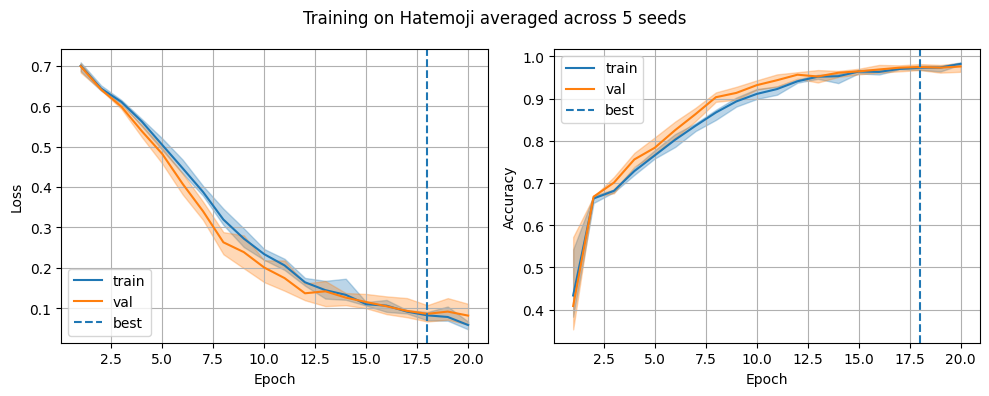

Best (mean) validation accuracy: 0.9786368260427263


In [29]:


with open(f"mega_hatemoji_seeds.obj", "rb") as f:
    best_train_accs, best_val_accs, best_train_losses, best_val_losses, best_epochs, all_train_accs, all_train_losses, all_val_accs, all_val_losses = pickle.load(f)

# Plot with epochs
def aggregate_over_seeds(data, epochs):
    means = []
    mins = []
    maxs = []
    padded_data = []
    for seed_data in data:
        # some seeds may have stopped early
        # hence pad with edge values
        padded_data.append(np.pad(seed_data, (0, epochs-len(seed_data)), 'edge'))
    for epoch in range(N_EPOCHS):
        epoch_data = torch.Tensor([seed[epoch] for seed in padded_data])
        means.append(torch.mean(epoch_data))
        mins.append(torch.min(epoch_data))
        maxs.append(torch.max(epoch_data))
    
    return means, mins, maxs

mean_train_accs, min_train_accs, max_train_accs = aggregate_over_seeds(all_train_accs, N_EPOCHS)
mean_val_losses, min_val_losses, max_val_losses= aggregate_over_seeds(all_val_losses, N_EPOCHS)
mean_val_accs, min_val_accs, max_val_accs = aggregate_over_seeds(all_val_accs, N_EPOCHS)
mean_train_losses, min_train_losses, max_train_losses = aggregate_over_seeds(all_train_losses, N_EPOCHS)

os.makedirs(f"figures/", exist_ok=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
epoch_axis = range(1, N_EPOCHS+1)
ax[0].plot(epoch_axis, mean_train_losses, color='C0', label='train')
ax[0].fill_between(epoch_axis, min_train_losses, max_train_losses, color='C0', alpha=0.3)
ax[0].plot(epoch_axis, mean_val_losses, color='C1', label='val')
ax[0].fill_between(epoch_axis, min_val_losses, max_val_losses, color='C1', alpha=0.3)
ax[0].axvline(best_epoch+1, label='best', linestyle='--')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
#ax[0].set_xticks(epoch_axis)
ax[0].grid()
ax[0].legend()

ax[1].plot(epoch_axis, mean_train_accs, color='C0', label='train')
ax[1].fill_between(epoch_axis, min_train_accs, max_train_accs, color='C0', alpha=0.3)
ax[1].plot(epoch_axis, mean_val_accs, color='C1', label='val')
ax[1].fill_between(epoch_axis, min_val_accs, max_val_accs, color='C1', alpha=0.3)
ax[1].axvline(best_epoch+1, label='best', linestyle='--')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
#ax[1].set_xticks(epoch_axis)
ax[1].grid()
ax[1].legend()
fig.suptitle(f"Training on Hatemoji averaged across {N_SEEDS} seeds")
plt.tight_layout()
plt.savefig(f"figures/epochs_{N_SEEDS}seeds")
plt.show()

print(f"Best (mean) validation accuracy: {np.mean(best_val_accs)}")

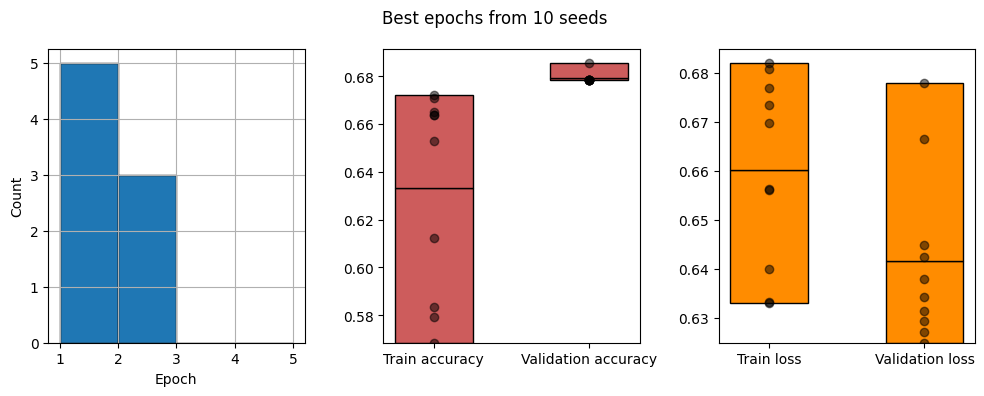

In [ ]:
# Only consider best epochs

def plot_errorbar(ax, name: str, data, color):
    bottom = torch.min(data)
    middle = torch.mean(data)
    height = torch.max(data) - middle
    #err = np.abs(torch.tensor([torch.min(data), torch.max(data)]) - torch.mean(data)).unsqueeze(1)
    #ax.errorbar(name, torch.mean(data), yerr=err, fmt='o', color=color, capsize=12)
    ax.bar(name, middle-bottom, bottom=bottom, color=color, width=0.5, ec='k')
    ax.bar(name, height, bottom=middle, color=color, width=0.5, ec='k')
    ax.scatter([name for _ in range(len(data))], data, alpha=0.5, color='k')

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].hist(best_epochs, bins=np.arange(1, N_EPOCHS+1), ec='k')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Count")

plot_errorbar(ax[1], 'Train accuracy', torch.Tensor(best_train_accs), 'indianred')
plot_errorbar(ax[1], 'Validation accuracy', torch.Tensor(best_val_accs), 'indianred')

plot_errorbar(ax[2], 'Train loss', torch.Tensor(best_train_losses), 'darkorange')
plot_errorbar(ax[2], 'Validation loss', torch.Tensor(best_val_losses), 'darkorange')

fig.suptitle("Best epochs from 10 seeds")
plt.tight_layout()
plt.savefig(f"figures/best_epochs_from_10seeds")
plt.show()


  0%|          | 0/16 [00:00<?, ?it/s]

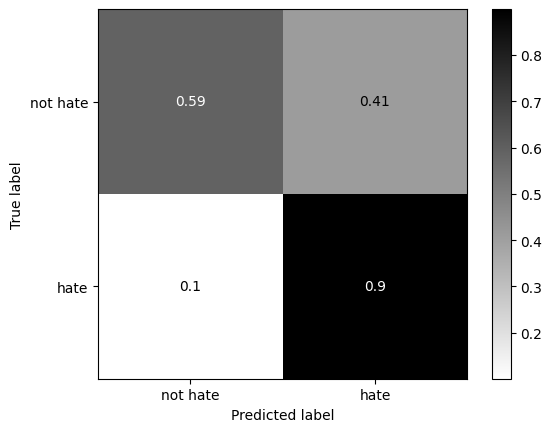

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

def eval_confusion(model, test_dataloader):
    progress_bar = tqdm(range(len(test_dataloader)))
    model.eval()
    confusion_metric = evaluate.load("confusion_matrix")

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        confusion_metric.add_batch(predictions=predictions, references=batch["labels"])

        progress_bar.update(1)

    confusion_matrix = confusion_metric.compute()["confusion_matrix"]

    return np.array(confusion_matrix)

model.load_state_dict(best_model)
confusion_matrix = eval_confusion(model, test_dataloader)
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_normalized, display_labels=('not hate','hate'))
disp.plot(cmap=plt.cm.binary)

plt.savefig(f"hatemoji_confusion.png", dpi=300, bbox_inches='tight')